<a href="https://colab.research.google.com/github/nikeshbekkam/UK-house-price-index-Prediction-using-TIme-series-Model/blob/main/uk_hpi_Dec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UK House Price Index (UK HPI)
### Time Series Modelling (ARIMA, ARIMAX, ETS)

This notebook performs a full ready pipeline:
1. Load and clean the UK HPI dataset
2. Exploratory Data Analysis (EDA)
3. Build a monthly national-level time series of `AveragePrice`
4. Train/test split with log transform
5. Stationarity checks (ADF) and ACF/PACF
6. Model 1: ARIMA (benchmark)
7. Model 2: ARIMAX with exogenous variables
8. Model 3: ETS (Holt–Winters)
9. Model comparison using RMSE, MAE, MAPE
10. Saving models and results for reproducibility


## Imports


In [36]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress non-critical warnings for a cleaner notebook
warnings.filterwarnings("ignore")

# Show all columns when displaying DataFrames
pd.set_option("display.max_columns", None)

# Output directory for saving plots, models, and metrics
OUTPUT_DIR = "results_dissertation"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Setup complete. Output directory:", OUTPUT_DIR)

Setup complete. Output directory: results_dissertation


## Load UK HPI Dataset

In [37]:

# Path to the UK HPI full file (adjust if needed)
DATA_PATH = "UK-HPI-full-file-2025-07.csv"

# Load the CSV into a DataFrame
df = pd.read_csv(DATA_PATH)

print("Shape (rows, columns):", df.shape)
display(df.head())

# Print info to inspect data types and non-null counts
df.info()

Shape (rows, columns): (147060, 54)


,Date,RegionName,AreaCode,AveragePrice,Index,IndexSA,1m%Change,12m%Change,AveragePriceSA,SalesVolume,DetachedPrice,DetachedIndex,Detached1m%Change,Detached12m%Change,SemiDetachedPrice,SemiDetachedIndex,SemiDetached1m%Change,SemiDetached12m%Change,TerracedPrice,TerracedIndex,Terraced1m%Change,Terraced12m%Change,FlatPrice,FlatIndex,Flat1m%Change,Flat12m%Change,CashPrice,CashIndex,Cash1m%Change,Cash12m%Change,CashSalesVolume,MortgagePrice,MortgageIndex,Mortgage1m%Change,Mortgage12m%Change,MortgageSalesVolume,FTBPrice,FTBIndex,FTB1m%Change,FTB12m%Change,FOOPrice,FOOIndex,FOO1m%Change,FOO12m%Change,NewPrice,NewIndex,New1m%Change,New12m%Change,NewSalesVolume,OldPrice,OldIndex,Old1m%Change,Old12m%Change,OldSalesVolume
0,01/01/2004,Aberdeenshire,S12000034,84638,41.1,NaN,NaN,NaN,NaN,388.0,130620.0,43.2,NaN,NaN,73972.0,40.9,NaN,NaN,58247.0,38.8,NaN,NaN,49322.0,45.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112843.0,40.7,NaN,NaN,103.0,81273.0,41.0,NaN,NaN,285.0
1,01/02/2004,Aberdeenshire,S12000034,84623,41.1,NaN,0.0,NaN,NaN,326.0,129330.0,42.7,-1.0,NaN,74225.0,41.1,0.3,NaN,58669.0,39.1,0.7,NaN,50364.0,46.7,2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113061.0,40.8,0.2,NaN,107.0,81194.0,40.9,-0.1,NaN,219.0
2,01/03/2004,Aberdeenshire,S12000034,86536,42.1,NaN,2.3,NaN,NaN,453.0,131585.0,43.5,1.7,NaN,76201.0,42.2,2.7,NaN,60399.0,40.2,2.9,NaN,51719.0,47.9,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115218.0,41.6,1.9,NaN,140.0,83137.0,41.9,2.4,NaN,313.0
3,01/04/2004,Aberdeenshire,S12000034,87373,42.5,NaN,1.0,NaN,NaN,571.0,130454.0,43.1,-0.9,NaN,78082.0,43.2,2.5,NaN,62326.0,41.5,3.2,NaN,53143.0,49.2,2.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115247.0,41.6,0.0,NaN,180.0,84241.0,42.5,1.3,NaN,391.0
4,01/05/2004,Aberdeenshire,S12000034,89493,43.5,NaN,2.4,NaN,NaN,502.0,132762.0,43.9,1.8,NaN,80340.0,44.5,2.9,NaN,64442.0,42.9,3.4,NaN,54678.0,50.7,2.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117377.0,42.4,1.8,NaN,167.0,86466.0,43.6,2.6,NaN,335.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147060 entries, 0 to 147059
Data columns (total 54 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Date                    147060 non-null  object 
 1   RegionName              147060 non-null  object 
 2   AreaCode                147060 non-null  object 
 3   AveragePrice            147060 non-null  int64  
 4   Index                   147060 non-null  float64
 5   IndexSA                 5169 non-null    float64
 6   1m%Change               146607 non-null  float64
 7   12m%Change              142200 non-null  float64
 8   AveragePriceSA          5169 non-null    float64
 9   SalesVolume             142593 non-null  float64
 10  DetachedPrice           140319 non-null  float64
 11  DetachedIndex           140319 non-null  float64
 12  Detached1m%Change       139924 non-null  float64
 13  Detached12m%Change      135603 non-null  float64
 14  SemiDetachedPrice   

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Type Conversion and Basic Cleaning

In [39]:
# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Identify non-numeric columns
non_numeric = ["Date", "RegionName", "AreaCode"]
numeric_cols = [c for c in df.columns if c not in non_numeric]

# Convert all numeric columns to numeric types (coerce errors to NaN)
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

print("Completed type conversions.")
print("Numeric columns:", len(numeric_cols))
display(df.head())

Completed type conversions.
Numeric columns: 51


,Date,RegionName,AreaCode,AveragePrice,Index,IndexSA,1m%Change,12m%Change,AveragePriceSA,SalesVolume,DetachedPrice,DetachedIndex,Detached1m%Change,Detached12m%Change,SemiDetachedPrice,SemiDetachedIndex,SemiDetached1m%Change,SemiDetached12m%Change,TerracedPrice,TerracedIndex,Terraced1m%Change,Terraced12m%Change,FlatPrice,FlatIndex,Flat1m%Change,Flat12m%Change,CashPrice,CashIndex,Cash1m%Change,Cash12m%Change,CashSalesVolume,MortgagePrice,MortgageIndex,Mortgage1m%Change,Mortgage12m%Change,MortgageSalesVolume,FTBPrice,FTBIndex,FTB1m%Change,FTB12m%Change,FOOPrice,FOOIndex,FOO1m%Change,FOO12m%Change,NewPrice,NewIndex,New1m%Change,New12m%Change,NewSalesVolume,OldPrice,OldIndex,Old1m%Change,Old12m%Change,OldSalesVolume
0,2004-01-01,Aberdeenshire,S12000034,84638,41.1,NaN,NaN,NaN,NaN,388.0,130620.0,43.2,NaN,NaN,73972.0,40.9,NaN,NaN,58247.0,38.8,NaN,NaN,49322.0,45.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112843.0,40.7,NaN,NaN,103.0,81273.0,41.0,NaN,NaN,285.0
1,2004-01-02,Aberdeenshire,S12000034,84623,41.1,NaN,0.0,NaN,NaN,326.0,129330.0,42.7,-1.0,NaN,74225.0,41.1,0.3,NaN,58669.0,39.1,0.7,NaN,50364.0,46.7,2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113061.0,40.8,0.2,NaN,107.0,81194.0,40.9,-0.1,NaN,219.0
2,2004-01-03,Aberdeenshire,S12000034,86536,42.1,NaN,2.3,NaN,NaN,453.0,131585.0,43.5,1.7,NaN,76201.0,42.2,2.7,NaN,60399.0,40.2,2.9,NaN,51719.0,47.9,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115218.0,41.6,1.9,NaN,140.0,83137.0,41.9,2.4,NaN,313.0
3,2004-01-04,Aberdeenshire,S12000034,87373,42.5,NaN,1.0,NaN,NaN,571.0,130454.0,43.1,-0.9,NaN,78082.0,43.2,2.5,NaN,62326.0,41.5,3.2,NaN,53143.0,49.2,2.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115247.0,41.6,0.0,NaN,180.0,84241.0,42.5,1.3,NaN,391.0
4,2004-01-05,Aberdeenshire,S12000034,89493,43.5,NaN,2.4,NaN,NaN,502.0,132762.0,43.9,1.8,NaN,80340.0,44.5,2.9,NaN,64442.0,42.9,3.4,NaN,54678.0,50.7,2.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117377.0,42.4,1.8,NaN,167.0,86466.0,43.6,2.6,NaN,335.0


## Exploratory Data Analysis (EDA)

### Missing Values and Duplicates

Missing values per column (top 20):
IndexSA                141891
AveragePriceSA         141891
Mortgage12m%Change      87868
FOO12m%Change           87868
Cash12m%Change          87868
FTB12m%Change           87472
CashSalesVolume         83954
MortgageSalesVolume     83951
Cash1m%Change           83556
Mortgage1m%Change       83556
FOO1m%Change            83556
FOOIndex                83164
MortgageIndex           83164
CashPrice               83164
MortgagePrice           83164
CashIndex               83164
FOOPrice                83164
FTB1m%Change            83160
FTBPrice                82768
FTBIndex                82768
dtype: int64

Total duplicate rows: 0


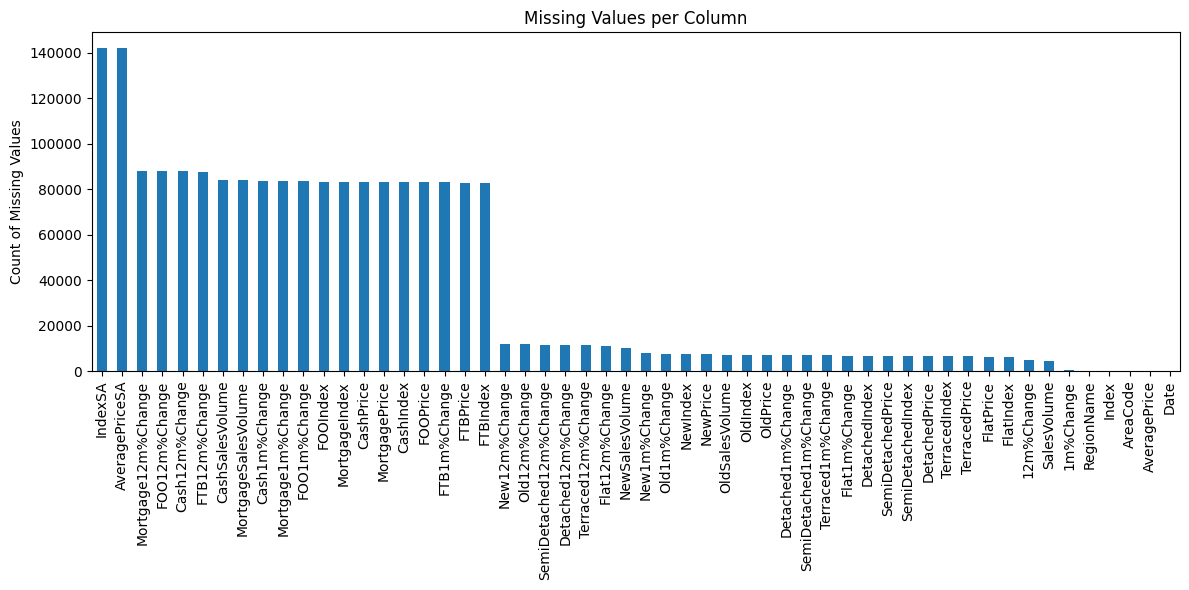

In [40]:

# Count missing values per column
missing = df.isna().sum().sort_values(ascending=False)
print("Missing values per column (top 20):")
print(missing.head(20))

# Count duplicate rows
dup_count = df.duplicated().sum()
print("\nTotal duplicate rows:", dup_count)

# Bar plot of missing values
plt.figure(figsize=(12, 6))
missing.plot(kind="bar")
plt.title("Missing Values per Column")
plt.ylabel("Count of Missing Values")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "missing_values.png"), dpi=300)
plt.show()

### Summary Statistics for Numeric Variables

In [41]:
# Descriptive statistics for numeric columns
desc_stats = df.describe().T
display(desc_stats)

,count,mean,min,25%,50%,75%,max,std
Date,147060,2009-07-12 06:39:02.423500544,1968-01-04 00:00:00,2002-01-09 00:00:00,2010-01-06 00:00:00,2018-01-01 00:00:00,2025-01-07 00:00:00,NaN
AveragePrice,147060.0,181389.087366,2553.0,99662.75,153262.0,227862.25,1656986.0,130161.915826
Index,147060.0,59.25624,0.8,37.3,60.7,79.5,153.1,26.326855
IndexSA,5169.0,61.557303,13.9,45.8,62.0,79.8,111.9,24.754778
1m%Change,146607.0,0.529999,-30.3,-0.5,0.5,1.5,35.3,1.940279
12m%Change,142200.0,6.162483,-35.8,1.1,5.2,10.2,98.4,8.660919
AveragePriceSA,5169.0,167213.066164,39008.0,114968.0,152059.0,206621.0,574627.0,94022.453488
SalesVolume,142593.0,1251.860905,2.0,140.0,215.0,377.0,183609.0,7705.090289
DetachedPrice,140319.0,338756.574242,40117.0,177370.0,257939.0,391805.5,5820174.0,340070.528965
DetachedIndex,140319.0,59.357947,9.4,40.5,59.7,78.9,147.0,24.897845


### Regional Average Prices (Top 10 Regions)

Top 10 regions by average price:


,AveragePrice
RegionName,
Kensington and Chelsea,920437.959128
City of Westminster,669499.558583
Camden,531702.337875
Hammersmith and Fulham,521143.681199
City of London,494692.065395
Richmond upon Thames,471495.370572
Wandsworth,449841.594005
Elmbridge,437012.040872
Islington,423316.098093


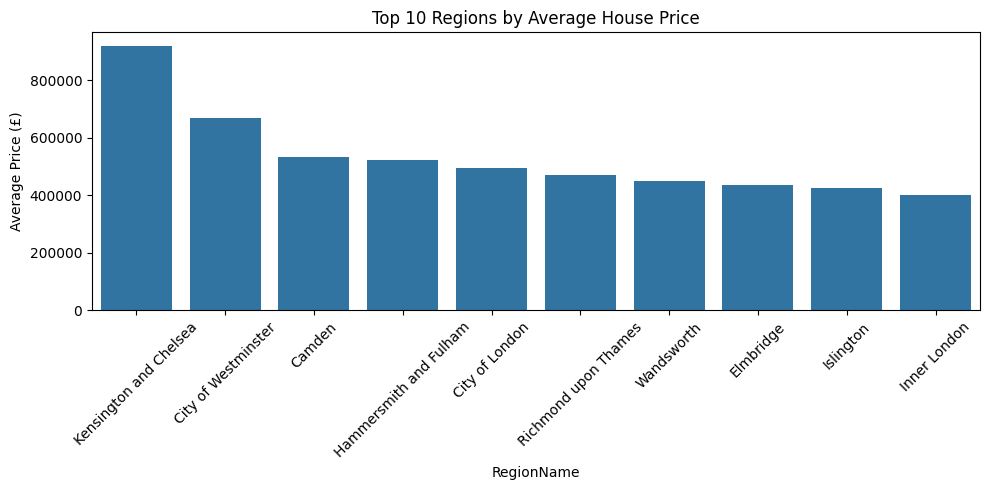

In [42]:

# Compute mean AveragePrice per RegionName
region_mean = (
    df.groupby("RegionName", dropna=False)["AveragePrice"]
    .mean()
    .sort_values(ascending=False)
)

top10 = region_mean.head(10)
print("Top 10 regions by average price:")
display(top10)

# Bar plot of top 10 regions
plt.figure(figsize=(10, 5))
sns.barplot(x=top10.index, y=top10.values)
plt.title("Top 10 Regions by Average House Price")
plt.ylabel("Average Price (£)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "top10_regions.png"), dpi=300)
plt.show()

### UK-wide Average House Price Trend Over Time

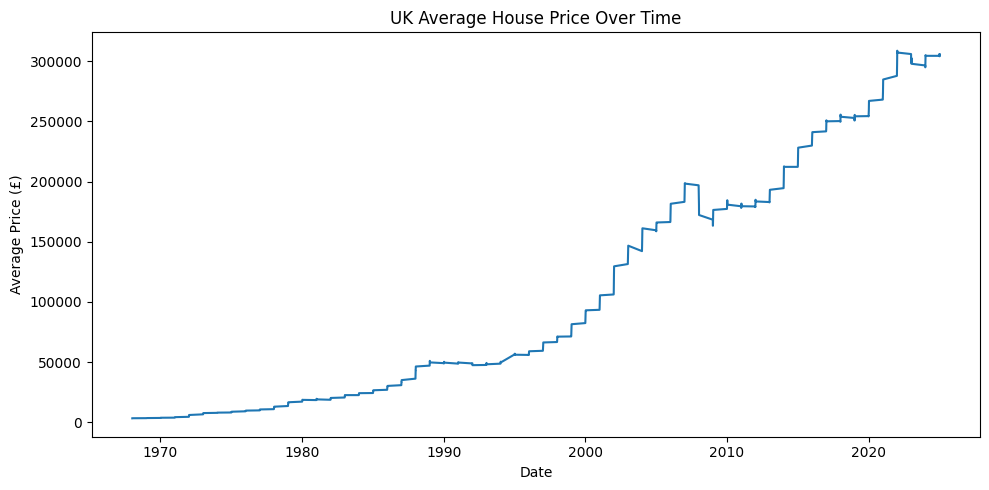

In [43]:
# Aggregate AveragePrice by Date (UK-wide mean)
uk_trend = df.groupby("Date", dropna=False)["AveragePrice"].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(uk_trend["Date"], uk_trend["AveragePrice"])
plt.title("UK Average House Price Over Time")
plt.xlabel("Date")
plt.ylabel("Average Price (£)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "uk_trend.png"), dpi=300)
plt.show()

## Build Monthly National-Level Time Series

Monthly time series head:


,AveragePrice
Date,
1968-02-01,NaN
1968-03-01,NaN
1968-04-01,NaN
1968-05-01,NaN
1968-06-01,NaN


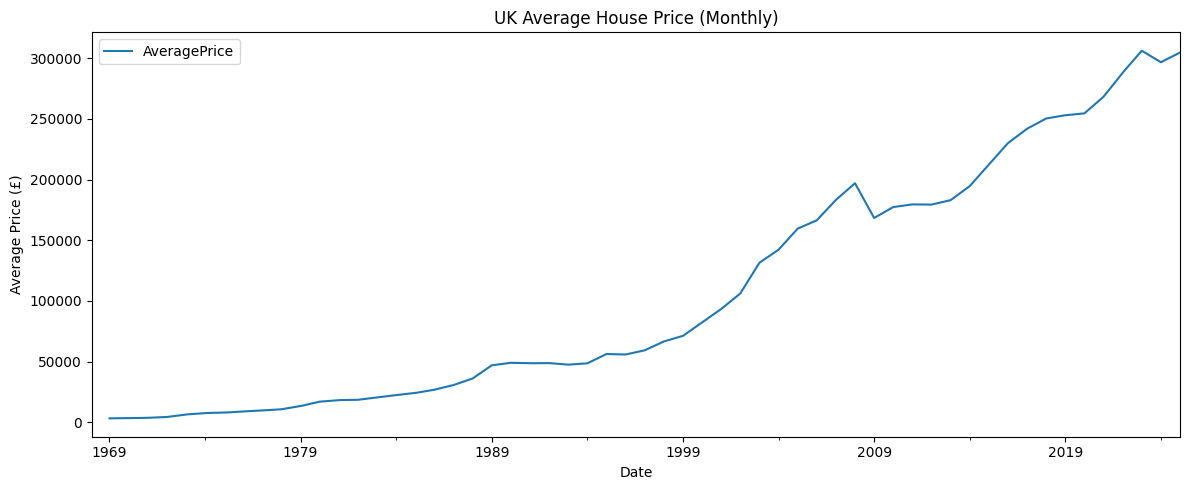

In [44]:
# Aggregate AveragePrice by Date into a monthly time series
df_monthly = df.groupby("Date")["AveragePrice"].mean().to_frame()

# Force a regular monthly-start frequency
df_monthly = df_monthly.asfreq("MS")

# Fill missing months by linear interpolation
df_monthly["AveragePrice"] = df_monthly["AveragePrice"].interpolate()

print("Monthly time series head:")
display(df_monthly.head())

# Plot the monthly UK-wide house price series
df_monthly.plot(figsize=(12, 5), title="UK Average House Price (Monthly)")
plt.ylabel("Average Price (£)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "uk_monthly_trend.png"), dpi=300)
plt.show()

## Train/Test Split and Log Transformation

In [45]:

# Log-transform AveragePrice to stabilise variance
y = np.log(df_monthly["AveragePrice"])
y = y.dropna()

# Choose test horizon (number of months held out)
test_horizon = 24  # last 24 months as test set

# Split into training and test sets
y_train = y.iloc[:-test_horizon]
y_test = y.iloc[-test_horizon:]

print("Train period:", y_train.index.min(), "to", y_train.index.max())
print("Test period :", y_test.index.min(), "to", y_test.index.max())
print("Training length:", len(y_train), "Test length:", len(y_test))

Train period: 1969-01-01 00:00:00 to 2023-01-01 00:00:00
Test period : 2023-02-01 00:00:00 to 2025-01-01 00:00:00
Training length: 649 Test length: 24


## Stationarity Check and ACF/PACF Analysis

ADF Statistic: -2.777287189341155
p-value      : 0.061592088145671874
Critical Values:
    1%: -3.4406900498266193
    5%: -2.8661023102613137
    10%: -2.569199643499287


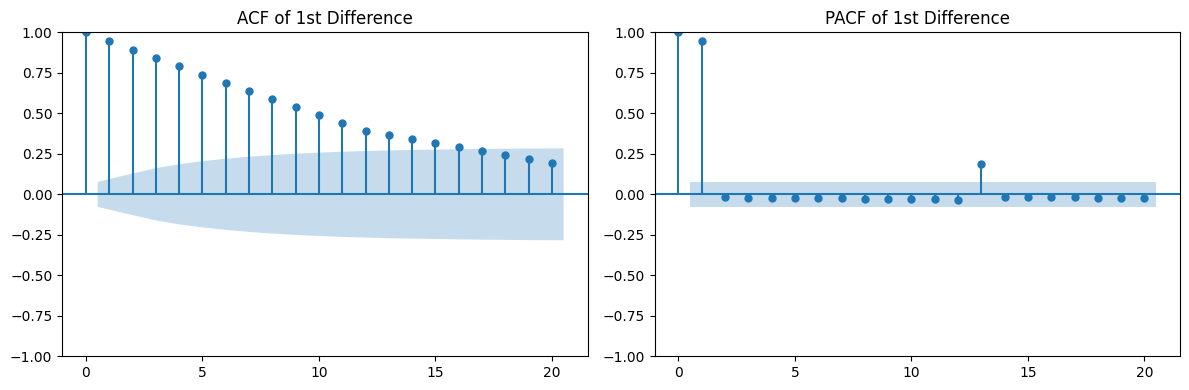

In [46]:

# Augmented Dickey–Fuller test on the training series
adf_result = adfuller(y_train)
print("ADF Statistic:", adf_result[0])
print("p-value      :", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"    {key}: {value}")

# First difference of log prices (for ACF/PACF)
y_diff = y_train.diff().dropna()

# Plot ACF and PACF for the differenced series
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(y_diff, ax=ax[0], lags=20)
plot_pacf(y_diff, ax=ax[1], lags=20, method="ywm")
ax[0].set_title("ACF of 1st Difference")
ax[1].set_title("PACF of 1st Difference")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "acf_pacf.png"), dpi=300)
plt.show()

## Helper Function: Forecast Accuracy Metrics

In [47]:

def evaluate_forecast(y_true, y_pred, model_name="model"):
    """
    Compute RMSE, MAE, and MAPE between true and predicted values.
    Both y_true and y_pred should be on the original (non-log) scale.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"{model_name} – RMSE: {rmse:,.2f} | MAE: {mae:,.2f} | MAPE: {mape:,.2f}%")
    return rmse, mae, mape

## Model 1 - ARIMA

                                    SARIMAX Results                                     
Dep. Variable:                     AveragePrice   No. Observations:                  649
Model:             ARIMA(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                2835.391
Date:                          Fri, 02 Jan 2026   AIC                          -5662.782
Time:                                  02:32:42   BIC                          -5644.961
Sample:                              01-01-1969   HQIC                         -5655.862
                                   - 01-01-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8818      0.037     24.050      0.000       0.810       0.954
ma.L1          0.0538      0.197      0.274      0.

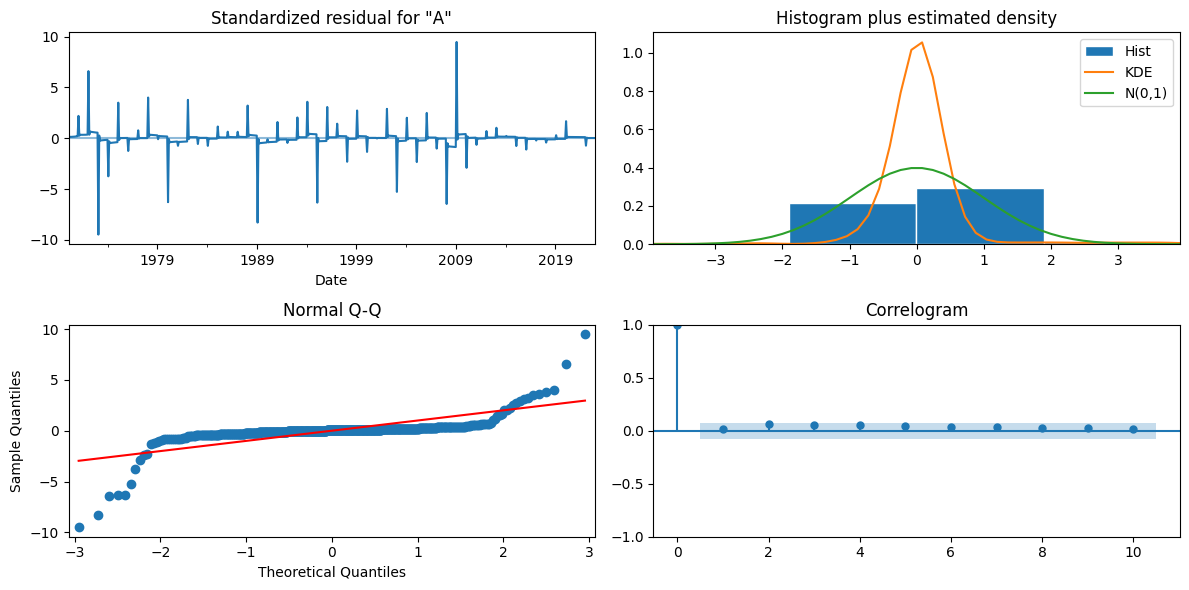

ARIMA – RMSE: 28,255.00 | MAE: 25,665.65 | MAPE: 8.54%


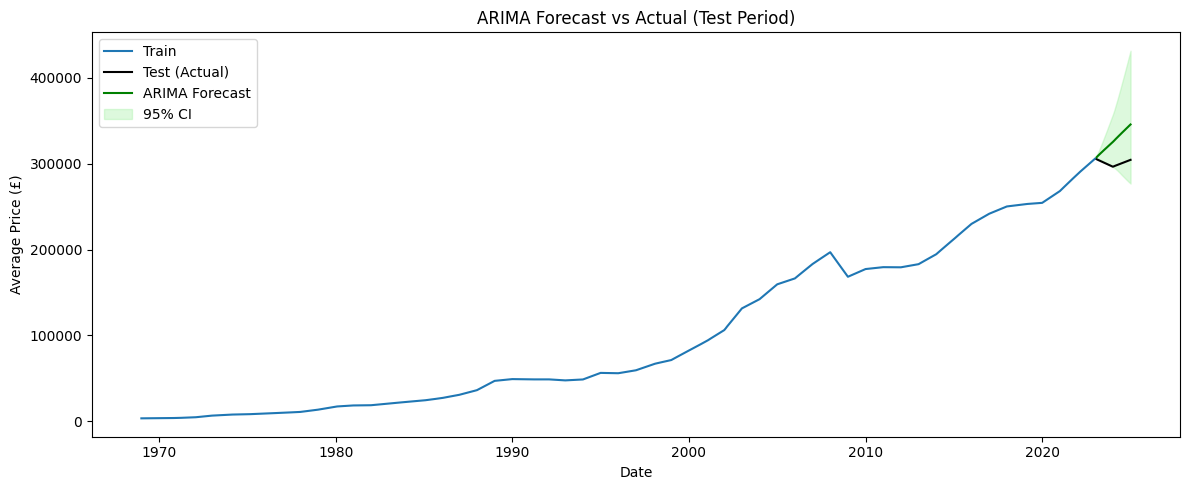

In [48]:

# Chosen order based on ACF/PACF and prior experimentation
arima_order = (1, 1, 1)
seasonal_order = (0, 1, 1, 12)

# Fit ARIMA model on the training data (log scale)
arima_model = ARIMA(
    y_train,
    order=arima_order,
    seasonal_order=seasonal_order
)
arima_results = arima_model.fit()
print(arima_results.summary())

# Diagnostic plots for ARIMA residuals
arima_results.plot_diagnostics(figsize=(12, 6))
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "arima_diagnostics.png"), dpi=300)
plt.show()

# ----------------------------------------------------------
# ARIMA Forecast for Test Period
# ----------------------------------------------------------

# Forecast 24 steps ahead (on log scale)
arima_forecast_log = arima_results.get_forecast(steps=test_horizon)
arima_mean_log = arima_forecast_log.predicted_mean
arima_conf_int_log = arima_forecast_log.conf_int()

# Convert log forecasts back to original (£) scale
arima_pred = np.exp(arima_mean_log)
arima_lower = np.exp(arima_conf_int_log.iloc[:, 0])
arima_upper = np.exp(arima_conf_int_log.iloc[:, 1])

# Actual test values on original scale
y_test_lin = np.exp(y_test)

# Evaluate ARIMA forecast
arima_rmse, arima_mae, arima_mape = evaluate_forecast(
    y_test_lin, arima_pred, model_name="ARIMA"
)

# Plot ARIMA predictions vs actuals
plt.figure(figsize=(12, 5))
plt.plot(np.exp(y_train), label="Train")
plt.plot(y_test_lin, label="Test (Actual)", color="black")
plt.plot(arima_pred.index, arima_pred, label="ARIMA Forecast", color="green")
plt.fill_between(arima_pred.index, arima_lower, arima_upper,
                 color="lightgreen", alpha=0.3, label="95% CI")
plt.title("ARIMA Forecast vs Actual (Test Period)")
plt.xlabel("Date")
plt.ylabel("Average Price (£)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "arima_forecast_test.png"), dpi=300)
plt.show()

## Construct Exogenous Variables for ARIMAX

In [49]:
# ----------------------------------------------------------
# Exogenous Variables for ARIMAX
# ----------------------------------------------------------

# Set Date as index and ensure sorted order
df_sorted = df.set_index("Date").sort_index()

# Choose economically meaningful exogenous variables
exog_cols = ["DetachedPrice", "SemiDetachedPrice", "TerracedPrice", "SalesVolume"]

# Aggregate by date (mean) and ensure monthly frequency
X = df_sorted[exog_cols].groupby(df_sorted.index).mean().asfreq("MS")

# Fill missing values by forward/backward fill
X = X.fillna(method="ffill").fillna(method="bfill")

# Align X to the same index as the target series y
X = X.reindex(y.index)
X = X.fillna(method="ffill").fillna(method="bfill")

# Train/test split for exogenous variables
X_train = X.iloc[:-test_horizon]
X_test = X.iloc[-test_horizon:]

print("Exogenous variables (train) shape:", X_train.shape)
print("Exogenous variables (test) shape :", X_test.shape)
display(X.head())

Exogenous variables (train) shape: (649, 4)
Exogenous variables (test) shape : (24, 4)


,DetachedPrice,SemiDetachedPrice,TerracedPrice,SalesVolume
Date,,,,
1969-01-01,103393.386555,60318.501401,46974.240896,643.226257
1969-02-01,103393.386555,60318.501401,46974.240896,643.226257
1969-03-01,103393.386555,60318.501401,46974.240896,643.226257
1969-04-01,103393.386555,60318.501401,46974.240896,643.226257
1969-05-01,103393.386555,60318.501401,46974.240896,643.226257


## 10. Model 2 – ARIMAX

                                     SARIMAX Results                                      
Dep. Variable:                       AveragePrice   No. Observations:                  649
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                2777.032
Date:                            Fri, 02 Jan 2026   AIC                          -5538.064
Time:                                    02:32:52   BIC                          -5502.600
Sample:                                01-01-1969   HQIC                         -5524.281
                                     - 01-01-2023                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
DetachedPrice      2.208e-08   1.52e-07      0.145      0.885   -2.76e-07     3.2e-07
SemiDetachedPr

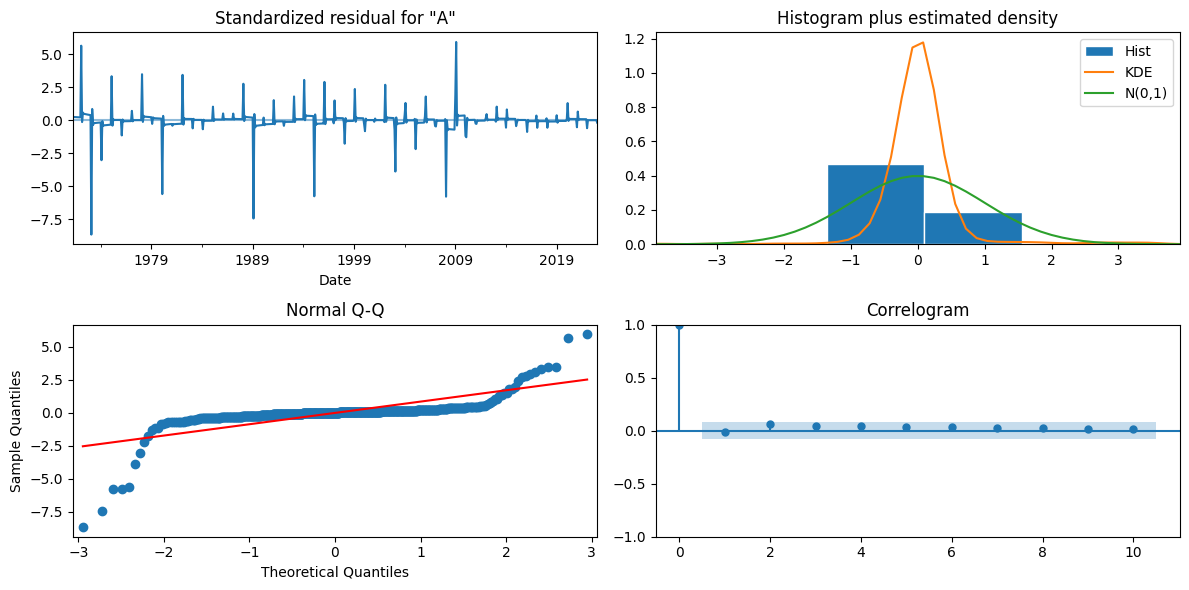

ARIMAX – RMSE: 25,328.32 | MAE: 23,142.57 | MAPE: 7.70%


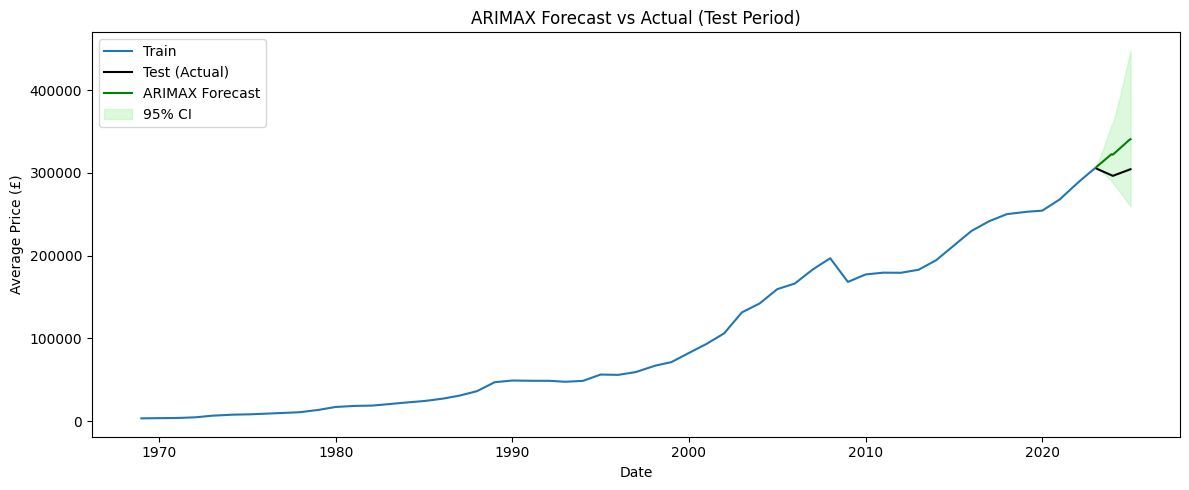

In [50]:

# Use the same ARIMA orders as the benchmark model
arimax_model = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=arima_order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

arimax_results = arimax_model.fit()
print(arimax_results.summary())

# Diagnostic plots for ARIMAX residuals
arimax_results.plot_diagnostics(figsize=(12, 6))
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "arimax_diagnostics.png"), dpi=300)
plt.show()

# ----------------------------------------------------------
# ARIMAX Forecast for Test Period
# ----------------------------------------------------------

# Forecast using exogenous variables for the test horizon
arimax_forecast_log = arimax_results.get_forecast(steps=test_horizon, exog=X_test)
arimax_mean_log = arimax_forecast_log.predicted_mean
arimax_conf_int_log = arimax_forecast_log.conf_int()

# Convert back to original (£) scale
arimax_pred = np.exp(arimax_mean_log)
arimax_lower = np.exp(arimax_conf_int_log.iloc[:, 0])
arimax_upper = np.exp(arimax_conf_int_log.iloc[:, 1])

# Evaluate ARIMAX forecast against actual test values
arimax_rmse, arimax_mae, arimax_mape = evaluate_forecast(
    y_test_lin, arimax_pred, model_name="ARIMAX"
)

# Plot ARIMAX predictions vs actuals
plt.figure(figsize=(12, 5))
plt.plot(np.exp(y_train), label="Train")
plt.plot(y_test_lin, label="Test (Actual)", color="black")
plt.plot(arimax_pred.index, arimax_pred, label="ARIMAX Forecast", color="green")
plt.fill_between(arimax_pred.index, arimax_lower, arimax_upper,
                 color="lightgreen", alpha=0.3, label="95% CI")
plt.title("ARIMAX Forecast vs Actual (Test Period)")
plt.xlabel("Date")
plt.ylabel("Average Price (£)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "arimax_forecast_test.png"), dpi=300)
plt.show()

## 11. Model 3 – ETS (Holt–Winters)

ETS model fitted.
ETS (Holt-Winters) – RMSE: 30,237.30 | MAE: 27,429.13 | MAPE: 9.12%


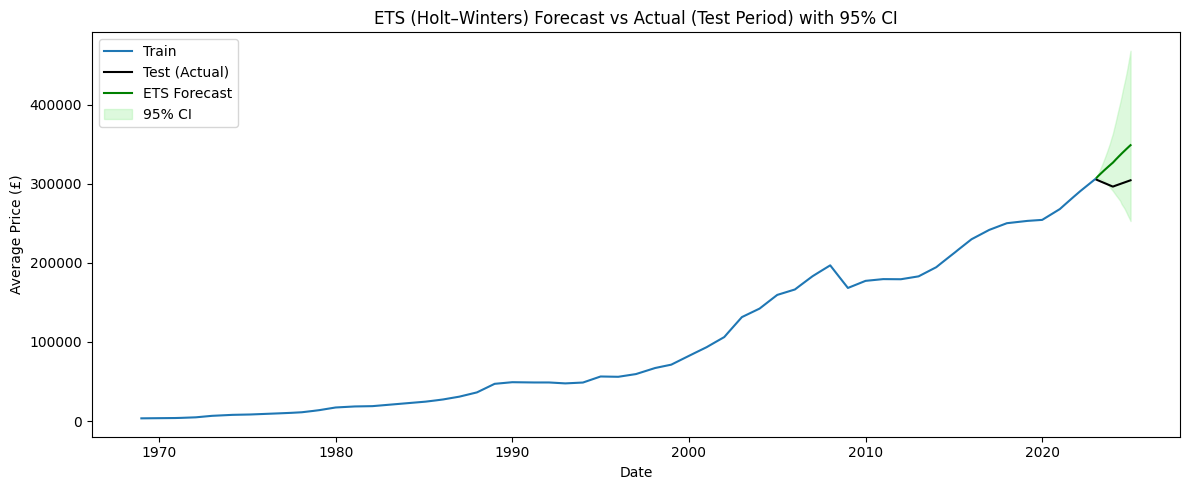

In [51]:
# Use the same log-transformed series and train/test split
y_log = y.copy()
y_train_ets = y_log.iloc[:-test_horizon]
y_test_ets  = y_log.iloc[-test_horizon:]

# -------------------------------
# Fit ETS model (log scale)
# -------------------------------
ets_model = ExponentialSmoothing(
    y_train_ets,
    trend="add",
    seasonal="add",
    seasonal_periods=12,
    initialization_method="estimated"
).fit(optimized=True)

print("ETS model fitted.")

# -------------------------------
# Point forecast (log -> £)
# -------------------------------
ets_forecast_log = ets_model.forecast(steps=test_horizon)
ets_pred = np.exp(ets_forecast_log)

# -------------------------------
# 95% Prediction Interval (simulation)
# -------------------------------
# We simulate many possible future paths from the fitted ETS model,
# then take the 2.5% and 97.5% quantiles at each horizon step.
n_sims = 2000  # increase for smoother intervals (e.g., 5000) if you want
sim_log = ets_model.simulate(
    nsimulations=test_horizon,
    repetitions=n_sims,
    anchor="end"          # start simulating from end of training
)

# sim_log is (steps x repetitions). Convert to DataFrame for easy quantiles
sim_log_df = pd.DataFrame(sim_log, index=ets_forecast_log.index)

# Quantiles in log space
ets_lower_log = sim_log_df.quantile(0.025, axis=1)
ets_upper_log = sim_log_df.quantile(0.975, axis=1)

# Convert interval bounds back to £
ets_lower = np.exp(ets_lower_log)
ets_upper = np.exp(ets_upper_log)

# Actual test values on £ scale
y_test_ets_lin = np.exp(y_test_ets)

# -------------------------------
# Evaluate ETS forecast
# -------------------------------
ets_rmse, ets_mae, ets_mape = evaluate_forecast(
    y_test_ets_lin, ets_pred, model_name="ETS (Holt-Winters)"
)

# -------------------------------
# Plot ETS predictions vs actuals + 95% CI
# -------------------------------
plt.figure(figsize=(12, 5))
plt.plot(np.exp(y_train_ets), label="Train")
plt.plot(y_test_ets_lin, label="Test (Actual)", color="black")
plt.plot(ets_pred.index, ets_pred, label="ETS Forecast", color="green")

plt.fill_between(
    ets_pred.index,
    ets_lower,
    ets_upper,
    color="lightgreen",
    alpha=0.3,
    label="95% CI"
)

plt.title("ETS (Holt–Winters) Forecast vs Actual (Test Period) with 95% CI")
plt.xlabel("Date")
plt.ylabel("Average Price (£)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "ets_forecast_test_with_ci.png"), dpi=300)
plt.show()


## 12. Model Comparison (ARIMA vs ARIMAX vs ETS)

In [52]:

# Construct a DataFrame summarising the accuracy metrics
comparison = pd.DataFrame({
    "Model": ["ARIMA", "ARIMAX", "ETS (Holt-Winters)"],
    "RMSE": [arima_rmse, arimax_rmse, ets_rmse],
    "MAE": [arima_mae, arimax_mae, ets_mae],
    "MAPE (%)": [arima_mape, arimax_mape, ets_mape],
})

print("Model Comparison on 24-month Test Period:")
display(comparison)

# Save comparison table to CSV
comparison.to_csv(os.path.join(OUTPUT_DIR, "model_comparison_metrics.csv"), index=False)

Model Comparison on 24-month Test Period:


,Model,RMSE,MAE,MAPE (%)
0,ARIMA,28255.003562,25665.654575,8.538620
1,ARIMAX,25328.315178,23142.574685,7.699602
2,ETS (Holt-Winters),30237.295262,27429.131015,9.124719


## 13. Save Fitted Models for Reproducibility

In [53]:

# Save fitted models to disk for future reuse
arima_results.save(os.path.join(OUTPUT_DIR, "ARIMA_model.pkl"))
arimax_results.save(os.path.join(OUTPUT_DIR, "ARIMAX_model.pkl"))
ets_model.save(os.path.join(OUTPUT_DIR, "ETS_model.pkl"))

print("All models saved successfully in:", OUTPUT_DIR)

All models saved successfully in: results_dissertation
